In [1]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Part 0: Requirements

## Abstract 

In the movie industry, creativity is generally considered to be a key factor in the success of a film. Actors often need to reinvent themselves to keep audiences hooked, but do they really ? Some actors tend to develop a comfort zone and keep playing the same type of movies / characters. Our projects aims at discovering those comfort zones, when they are created and what happens when actors step out of it. Conversly, we also want to evaluate if a given role/character tends to be played only by a subset of actors and which feature/s these actors share, which could lead us to uncover racial or gender biases in film castings. We build on top of the results of the [original paper](http://www.cs.cmu.edu/~ark/personas/) in order to identify in a more fine-grained approach if an actors exhibit a recurring persona accross the characters they play.

## Research questions

1. What is the proportion of actors that tend to play the same type of movies ?
2. When did an actor start to play in similar movies/similar characters ?
3. Do actors exhibit a recurring persona accross the characters they play ?
4. Is there a clear distribution shift in the perfromance of a movie when this actor is/isn't in his comfort zone ?
5. Are there roles that are acclaimed only when they are played by a specific group of actors ?
6. Which features of an actor impact the distribution of his roles ?

## Download data 

In order to download all required datasets, run the cell bellow (may take a while the first time).

In [2]:
%run src/preprocessing/download_dataset.py

[+] Found cached dataset for url https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/name.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.ratings.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.principals.tsv.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.cond.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureFile.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureMeans.txt.gz
[+] Found cached da

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [3]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [4]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
381015,8499338,/m/0275nc4,2005-05-10,Bartender,1962-04-27,M,NaN,NaN,James Chean,43.0,/m/0lfj863,/m/0lfj866,/m/026d9zx
237757,27745239,/m/0cc54fl,NaN,NaN,1987-05-27,M,NaN,NaN,Eric Kolelas,NaN,/m/0j_vt1s,NaN,/m/0ch2ss8
48136,5429993,/m/0b73wst,2006-08-07,Ms. Stephanie,1966-05-01,F,NaN,NaN,Anne Fletcher,40.0,/m/0h5pgyd,/m/0h5pgyh,/m/0f9p8x
190569,1271416,/m/04n_77,1950-08-12,NaN,1926-08-07,M,NaN,NaN,Stan Freberg,24.0,/m/052bl1q,NaN,/m/01lmk9k
276775,13623073,/m/03cc4f1,2000,TV Reporter,NaN,NaN,NaN,NaN,Holly Myers,NaN,/m/0kfh8bt,/m/0kfh8bx,/m/0kfh8c3


In [5]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

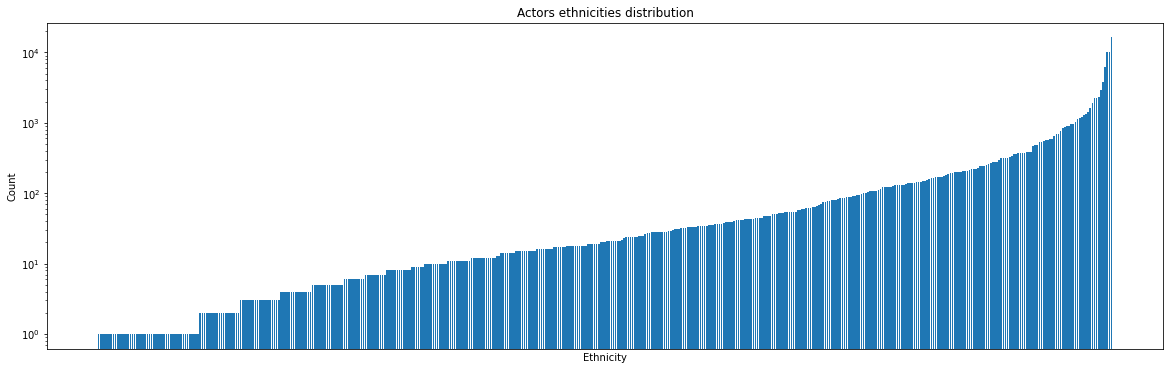

In [6]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [7]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
40508,3073220,/m/08pl90,Accattone,1961-11-22,NaN,116.0,{'/m/02bjrlw': 'Italian Language'},{'/m/03rjj': 'Italy'},"{'/m/07s9rl0': 'Drama', '/m/03q4nz': 'World ci..."
33017,25875068,/m/09v0rjh,"Tora-san, the Matchmaker",1979-08-04,NaN,107.0,{},{'/m/03_3d': 'Japan'},{'/m/0gw5n2f': 'Japanese Movies'}
78417,16575961,/m/03ychl5,*Corpus Callosum,2002,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},"{'/m/07s9rl0': 'Drama', '/m/0424mc': 'Experime..."
27870,14414193,/m/03d2sj2,Crossroads,1942-07,NaN,83.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/07s9rl0': 'Drama'..."
26110,29018533,/m/0dgpng3,The Rejuvenation of Aunt Mary,1927-08-08,NaN,60.0,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},{'/m/06ppq': 'Silent film'}


In [8]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [9]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

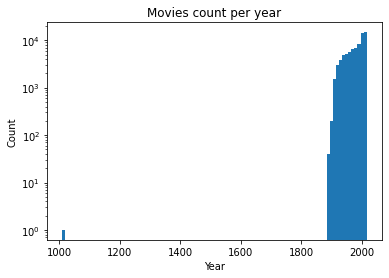

In [10]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [11]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [12]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

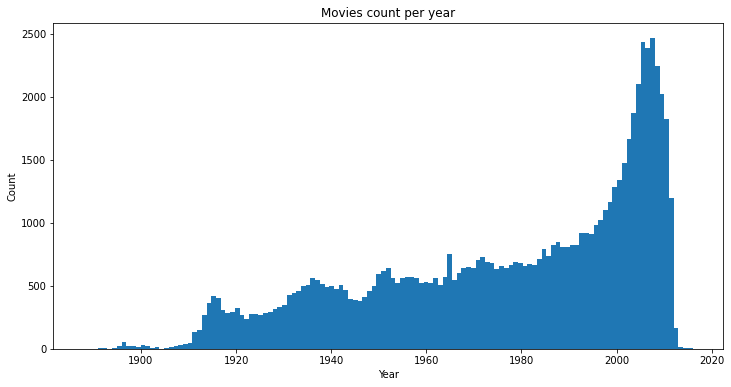

In [13]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plot

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [14]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
13431,5697845,The film revolves around the court-martial of ...
28887,2400759,The aging Books and the Old West are dying. Ar...
14986,35003577,"In the center of El-Madina lives Ali, a young ..."
18880,21843327,"The film is about the life of a farmer Kisna ,..."
41838,952902,Students at Steinmetz High School are less tha...


In [15]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [16]:
tvtropes_df.sample(5)

,trope_name,character_data
257,final_girl,"{'char': 'Nancy Thompson', 'movie': 'A Nightma..."
301,heartbroken_badass,"{'char': 'Tallahassee', 'movie': 'Zombieland',..."
286,grumpy_old_man,"{'char': 'Carl Fredricksen', 'movie': 'Up', 'i..."
57,bruiser_with_a_soft_center,"{'char': 'Hellboy', 'movie': 'Hellboy: Blood a..."
382,psycho_for_hire,"{'char': 'Gaear Grimsrud', 'movie': 'Fargo', '..."


In [17]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset


We need to define a metric of "success" of a film. Even if we are already provided with the `box_office` column in the cmu dataset, it only includes data for the bigger blockbusters, wihch represent only 10% of the movies. We have therefore decided to use the imdb rating of the film as a metric defining its performance.

We also used the `people` and `principals` collections from IMDb to enrich the `characters` collection from the CMU corpus, reducing the amount of missing information.

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [18]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

In [19]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
8363009,tt10276312,3,nm4436140,actor,\N,"[""Kevin Warhol""]"
1813572,tt0238799,7,nm0040772,actor,\N,"[""The Right Reverend Geoffrey Clayton (1997)""]"
19174189,tt13817654,3,nm12198414,actress,\N,\N
52473839,tt7680566,3,nm2124349,actress,\N,"[""Socorro""]"
38913461,tt28054208,7,nm3784099,actor,\N,"[""Jabir""]"


### Ratings

First let's explore the ratings dataframe.

In [20]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
1010939,tt3136556,7.9,349
196073,tt0337312,5.4,9
274144,tt0519902,5.7,77
1213763,tt6351142,7.3,57
1177526,tt5785602,8.2,35


We have 1365868 movies for which we have a rating.


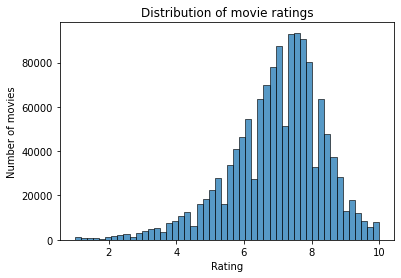

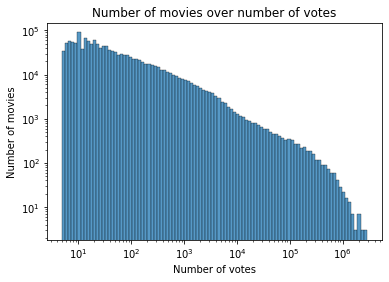

In [21]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [22]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
253370,tt0264615,movie,Foot Pursuit,Foot Pursuit,0,1994,\N,60,\N
5582042,tt21833466,movie,Quebrando Mitos,Quebrando Mitos,0,2022,\N,\N,[Documentary]
8616079,tt6263296,movie,Bhoyongkor Raja,Bhoyongkor Raja,0,2005,\N,\N,[Action]
344455,tt0359575,movie,"Kung ako'y patay na, sino ako?","Kung ako'y patay na, sino ako?",0,1975,\N,\N,[Thriller]
2985083,tt13691036,movie,Meskina,Meskina,0,2021,\N,98,[Comedy]


In [23]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 651888 movie titles


### Principals

In [24]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

imdb_principals_df.sample(5)

We have 58900432 principals records
We have 12 categories
We have 5169350 unique persons



,tconst,ordering,nconst,category,job,characters
15755744,tt1251654,1,nm0727961,self,\N,"[""Self - Co-Hostess""]"
2296949,tt0311850,4,nm0188266,actor,\N,"[""Tony""]"
16658380,tt12829670,6,nm0943827,self,\N,"[""Self""]"
4265216,tt0586205,4,nm0322728,actress,\N,\N
47706919,tt5754356,2,nm5457576,actress,\N,"[""Cleaning Lady""]"


### People

In [25]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[(imdb_people_df['primaryProfession'] == 'actor') | (imdb_people_df['primaryProfession'] == 'actress')])} unique actors")

imdb_people_df.sample(5)

We have 12978070 people records
We have 12978070 unique persons
We have 0 unique actors


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
2030555,nm11175828,Percy Davis,\N,\N,[actor],[tt11050872]
9832170,nm5999062,Chrispy Pickens,\N,\N,"[camera_department, sound_department]",[tt3242582]
11050292,nm7602774,Brian Backus,\N,\N,[art_department],[tt0092156]
947515,nm10028683,Johanna Tiidt,\N,\N,[actress],[tt2169443]
8283723,nm4180660,Laila Harris,\N,\N,[actress],"[tt2393813, tt1564349]"


### Movie titles with ratings

In [26]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')

total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

imdb_title_with_rating.sample(5)

We have 294744 movies with ratings


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
117216,tt0357736,movie,Heer,Heer,0,1956,\N,\N,[Romance],4.8,20
261585,tt5547320,movie,Cehennem Atesi,Cehennem Atesi,0,1987,\N,\N,[Adventure],5.1,9
156725,tt1171260,movie,Prosze slonia,Prosze slonia,0,1979,\N,63,[Animation],6.5,56
248000,tt4227402,movie,The True-Taste Show,Te-roo-mat-syo,0,2011,\N,65,[Documentary],7.8,10
52828,tt0096514,movie,Lovable Zanies II,Zärtliche Chaoten II,0,1988,\N,94,"[Comedy, Romance, Sci-Fi]",4.3,555


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [27]:
translation_id = load_translation_df()

imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44467 movies with corresponding ratings


In [28]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
44282,tt3463178,114,"[Biography, Drama, History]",6.9,1746,/m/03wf3fp,16253552,Saint Mary,2002,NaN,{'/m/032f6': 'Persian Language'},{'/m/03shp': 'Iran'},"{'/m/07s9rl0': 'Drama', '/m/0hj3n57': 'Hagiogr...","In the year 16 BCE, the people of Jerusalem ar..."
3257,tt0026629,85,[Comedy],6.8,188,/m/07s7fmz,24382201,Life Begins at Forty,1935,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/01z4y': 'Comedy', '/m/01g6gs': 'Black-and...",NaN
34389,tt0378793,89,[Drama],7.2,28779,/m/02nhxs,544413,Speak,2004-01-20,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/0219x_': 'Indie', ...",Melinda Sordino starts out her freshman year ...
24095,tt0107840,109,"[Drama, Romance]",6.1,16163,/m/06974q,1962192,Poetic Justice,1993-07-23,27515786.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/068d7h': 'Romantic drama', '/m/02l7c8': '...",Justice is a young woman living in South Cent...
25792,tt0118727,95,"[Drama, Thriller]",5.3,436,/m/03grqn0,14645904,Love Walked In,1997,NaN,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/01jfsb': 'Thriller', '/m/07s9rl0': 'Drama'}",Jack is a world-weary pianist and writer in a...


## Merge IMDB people and principals
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [29]:
titles_of_interest = set(cmu_movies_w_imdb_rating["tconst"].to_list())

imdb_people_not_nan = imdb_people_df[imdb_people_df["primaryProfession"].notna()]

imdb_actors = imdb_people_not_nan[imdb_people_not_nan["primaryProfession"].apply(lambda l : ("actor" in l) or ("actress" in l))].copy()
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

## Filter CMU characters
We keep records of interest in the same fashion as done above

In [30]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
415279,13814165,/m/03ck20l,2008-01-24,Queen Margo,1972-04-20,F,1.6,NaN,Carmen Electra,35.0,/m/040lfv6,/m/0gxp7pb,/m/01lbp
40207,6158544,/m/0ft8g4,2007,NaN,1971-02-24,F,NaN,NaN,Coralina Cataldi-Tassoni,35.0,/m/02vbvpt,NaN,/m/07fps1
184502,4049715,/m/0bfj1l,1996,NaN,1950-08-12,F,NaN,NaN,Iris Berben,45.0,/m/0cg1jh1,NaN,/m/02pz2j5
238703,1670736,/m/05m55b,1994-09-10,Jack,1957-03-12,M,NaN,/m/041rx,Jerry Levine,37.0,/m/021_h7d,/m/02nwn1f,/m/0g2s17
261305,1430127,/m/050xcx,1996-04-05,Charlie Sloan,NaN,M,NaN,NaN,Garry Sweeney,NaN,/m/0bqsgfn,/m/0bqsgfr,/m/0bqsgfz


## Merge IMDB actors and characters with CMU characters

We merge IMDB character and actor data with the CMU data. We make use of the movie translation dataframe again and the actor translation dataframe. We assume that an actor only plays one role in a movie. This is not necessarily true as some actors may play many roles in the same movie, but we assume that those cases are sufficiently rare so that we can ignore them.

In [31]:
# Actor translation dataframe
actor_translation_df = load_actors_translation_df()
actor_translation_df = actor_translation_df.rename(columns={'imdb_id' : 'actor_imdb_id', 'freebase_id' : 'actor_freebase_id'})

In [32]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.merge(actor_translation_df, how='inner', left_on='nconst', right_on='actor_imdb_id')
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id", "actor_imdb_id"], axis=1)

In [33]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'actor_freebase_id'], 
                                                                           right_on=['freebase_movie_id', 'freebase_actor_id']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "actor_freebase_id", "primaryName", "deathYear", "birthYear"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates(subset="freebase_map_id")

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
85389,nm0255764,"[tt0021021, tt0020474, tt0019072, tt0027607]",tt0019072,"[""Woman""]",/m/04d_ymn,18488791,1928-02-15,NaN,1901,F,NaN,NaN,Anielka Elter,NaN,/m/0g9hkqt,NaN,/m/02pn0yw
25530,nm0001277,"[tt0101393, tt0102926, tt1194173, tt0099810]",tt0190865,"[""Montgomery Wick""]",/m/05p14s,1695219,2000-12-08,Montgomery Wick,1941-01-26,M,1.83,/m/033tf_,Scott Glenn,59.0,/m/0k7qtr,/m/0cj3d4l,/m/04gc65
12156,nm0000472,"[tt0023194, tt0026138, tt0023245, tt0024894]",tt0023271,"[""'Happy' MacDonald""]",/m/027xf1k,9092969,1932-05-05,NaN,1887-11-23,M,1.80,/m/0d7wh,Boris Karloff,NaN,/m/040ghbv,NaN,/m/0hpz8
15203,nm0908919,"[tt0048973, tt0060196, tt0054047, tt0457939]",tt0079153,"[""Sal Hyman""]",/m/02qz_48,11069187,1979-04-27,Sal Hyman,1915-12-07,M,1.78,/m/041rx,Eli Wallach,63.0,/m/04dbh3q,/m/0h36zbc,/m/02vg0
63400,nm0002668,"[tt0096256, tt0088763, tt0080749, tt0088172]",tt0075629,"[""Ben""]",/m/02z0d67,12932124,1976-12-20,NaN,1937-10-28,M,NaN,NaN,George Buck Flower,39.0,/m/040jwg9,NaN,/m/06n2th


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [34]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [35]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,Guy Holden,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,Huckleberry Haines,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
2,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,Jerry Travers,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953
3,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0027630,"[""Bake Baker""]",/m/08d56_,2926860,1936-02-20,Bake Baker,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0jybbh,/m/0h184vt,/m/0h953
4,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0028333,"[""Lucky Garnett""]",/m/03pw28,919005,1936,Lucky Garnett,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k407p,/m/0h184vl,/m/0h953


In [36]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [37]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [38]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas
We now load the 500 personas records we extracted from TVTropes

In [39]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor
Let's see if actors have diverse tropes

In [40]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)
tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


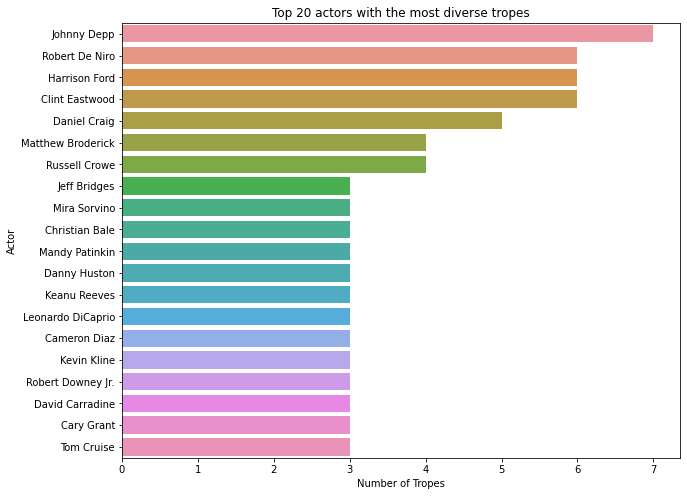

In [41]:
plt.figure(figsize=(10, 8))
sns.barplot(data = tvtropes_per_actor.head(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible with this dataset

### Preference Metric

As describe in the [`README.md`](./README.md#methods), we need a **preference metric** per actor. This metric should measure the tendency for a given actor $A$ to have a preferred trope (or set of tropes). A naïve approach would be to compare the distribution of a given actor $A$ to the uniform distribution of tropes. However a rapid analysis show us that the global tropes distribution is not uniform (and as such a more meaningful metric should be determined).



A more meaningfull metric need to be extracted

- **Cross Entropy based metric**:
    
    $$f(\text{Actor}) = \frac{ H(\text{Persona}) }{ H(\text{Persona} | \text{Actor})}$$
    
    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = +\infty$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 1$

In [42]:
# Implementation of the cross entropy per actors
tvtropes_per_actor_filtered = tvtropes_per_actor[tvtropes_per_actor["num_tropes"] > 3].copy()
tvtropes_per_actor_filtered

def compute_entropy(array_like):
    array_like = list(array_like)
    dic = {}
    for elem in array_like:
        dic[elem] = dic.get(elem, 0) + 1
    occurences = np.array(list(dic.values()))
    probabilities = occurences / np.sum(occurences)
    return -np.dot(np.log2(probabilities), probabilities)

H_global = compute_entropy(tvtropes_per_actor_filtered['trope'].sum())

tvtropes_per_actor_filtered['cross_entropy_based'] = H_global / tvtropes_per_actor_filtered['trope'].apply(compute_entropy)
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194


- **Mutual Information**:

    $$f(\text{Actor}) = \frac{I(\text{Persona}, \text{Actor})}{H(\text{Persona})} = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor}) }{H(\text{Persona})}$$

    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = 1$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 0$

In [43]:
tvtropes_per_actor_filtered['mutual_information_based'] = (H_global - tvtropes_per_actor_filtered['trope'].apply(compute_entropy)) / H_global
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based,mutual_information_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494,0.374411
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055,0.430542
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315,0.452749
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254,0.426360
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194,0.471792


### Analyse frequency of tropes when joined with our movies
This merging step is far from perfect as we have to merge on movie name, which is not a primary key. The generated data is widely unreliable, but we still plot it to get an idea of the distribution of personas.

In [44]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

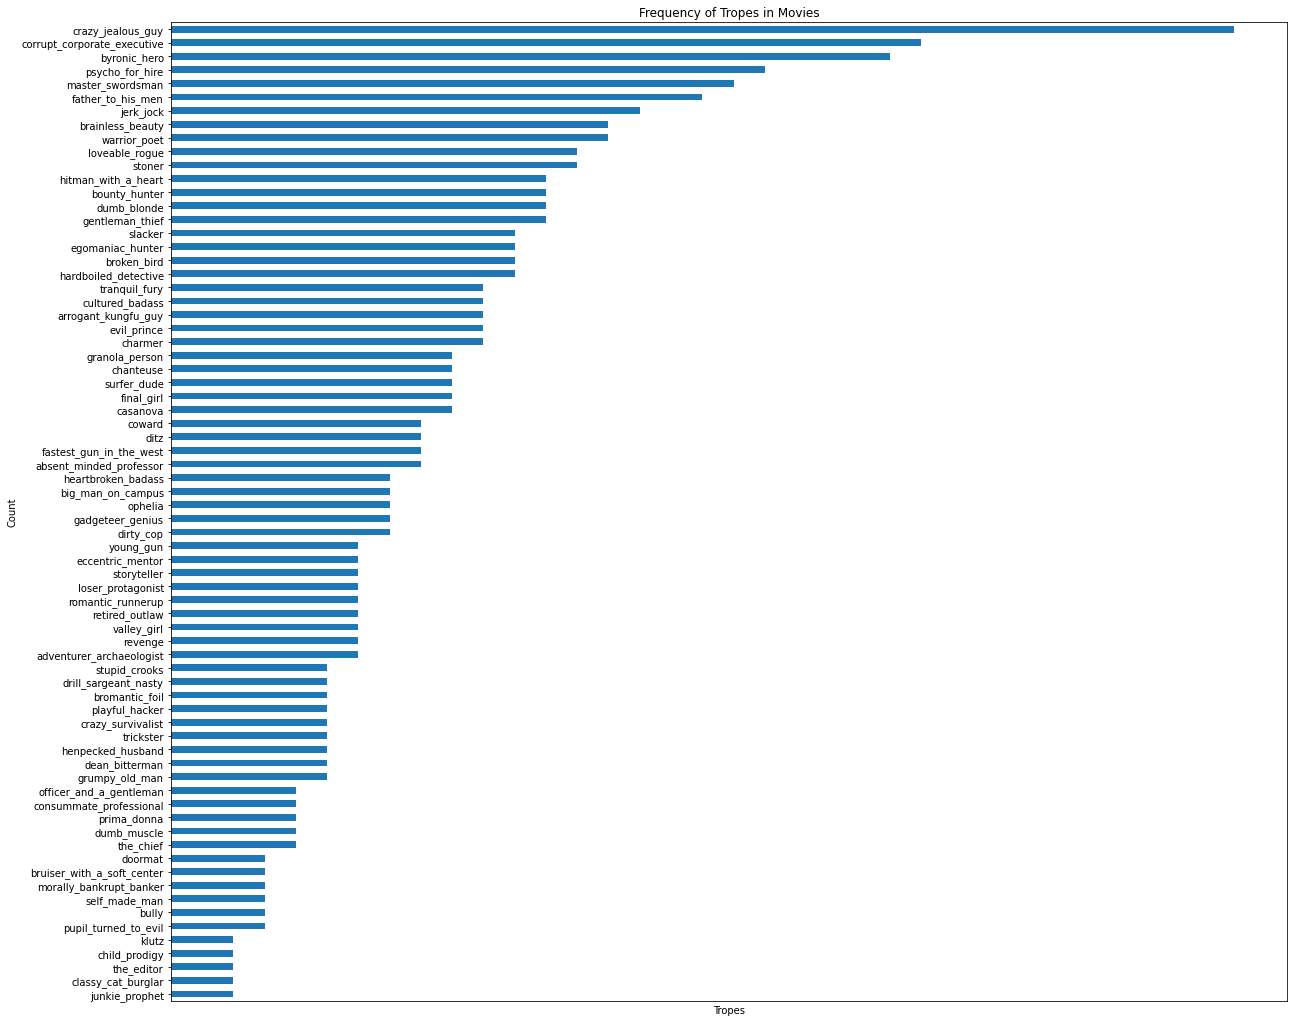

In [45]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh', xticks=[])
plt.xlabel('Tropes')
plt.ylabel('Count')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters
We merge the actors and characters information we extracted in part I with the personas from the original paper

In [46]:
cmu_personas = load_personas()
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
38124,e42,17049621,The Andromeda Strain,Scoop,a confidential mission to examine a wormhole t...,3,29,"[0.0, 0.26, 0.0, 0.0, 0.0, 0.01, 0.0, 0.02, 0...."
88041,e1,27070087,Boogie,wife,his wife,4,13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
46062,e15,18738928,Moggina Manasu,person,a person,3,3,"[0.0, 0.01, 0.18, 0.33, 0.0, 0.0, 0.02, 0.0, 0..."
54648,/m/0k3wgz,2051753,Stuck On You,April Mercedes,fellow aspiring actress April Mercedes,5,49,"[0.0, 0.0, 0.14, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0..."
85154,e1,26473841,Hipsters,mel,Mels,5,17,"[0.0, 0.0, 0.04, 0.0, 0.0, 0.01, 0.01, 0.0, 0...."


In [47]:
cmu_personas = cmu_personas.drop(columns=['secondary_name', 'full_name'])
cmu_personas = cmu_personas.rename(columns={'freebase_id' : 'freebase_map_id'})
movies_personas_cmu = cmu_personas.merge(actors_characters, on='freebase_map_id')

In [48]:
print(f"We have {len(movies_personas_cmu)} records for characters")

We have 15780 records for characters


This offers us one possiblity for further analysis, as we have more than 10'000 records

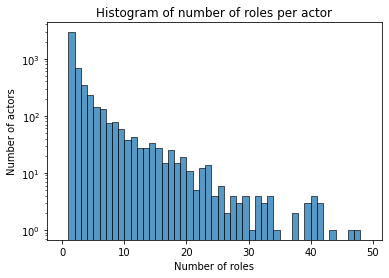

In [49]:
characters_per_actor = movies_personas_cmu[['freebase_actor_id', 'freebase_map_id']].groupby(by='freebase_actor_id').count()
sns.histplot(data=characters_per_actor, x='freebase_map_id', bins=range(50))
plt.yscale('log')
plt.xlabel("Number of roles")
plt.ylabel("Number of actors")
plt.title("Histogram of number of roles per actor")
plt.show()

In [50]:
print(f"Number of actors with 5 roles or more : {len(characters_per_actor[characters_per_actor['freebase_map_id'] >= 5])}")
print(f"Number of actors with less than 5 roles : {len(characters_per_actor[characters_per_actor['freebase_map_id'] < 5])}")

Number of actors with 5 roles or more : 850
Number of actors with less than 5 roles : 4186


With 5 roles or more, we consider that we can decide "with some confidence" if an actor has a preferred persona or not (under this threshold, data may not be significant enough). There is a reasonable proportion of actors for which we gathered enough roles to be confident in our analysis (roughly 20% of the original number of actors). 

Nevertheless, in further methods, we may decide to only keep actors with a number of roles greater than some threshold (to be confident in our metric computations). This may become a source of bias as there is more chance that an actor is successful if he plays in more movies (thus our analysis may become relevant only for "successful" actors and not for actors in general). 

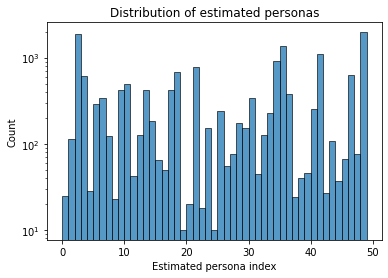

In [54]:
sns.histplot(data=movies_personas_cmu, x='estimated_trope', bins=range(50))
plt.yscale("log")
plt.xlabel('Estimated persona index')
plt.ylabel('Count')
plt.title('Distribution of estimated personas')
plt.show()

The distribution of estimated personas is very heterogeneous, some personas only have one representative ! This can lead to very high variance. For instance suppose for those personas that their representative (movie role) is in a very good movie (according to our movies' success evaluation), then we will deduce that this persona always lead to very good rating and will bias our analysis. We hope that this issue can be mitigated with uncertainty estimation.

## Movie-based comfort zones
We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor

In [63]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [64]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
2,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953
3,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0027630,"[""Bake Baker""]",/m/08d56_,2926860,1936-02-20,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0jybbh,/m/0h184vt,/m/0h953
4,nm0000001,"[tt0053137, tt0031983, tt0050419, tt0072308]",tt0028333,"[""Lucky Garnett""]",/m/03pw28,919005,1936,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k407p,/m/0h184vl,/m/0h953


In [65]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None,/m/0n5_12j
1,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None,/m/0n5_11v
2,tt0002101,100,"[Drama, History]",5.1,572,/m/04lghwf,19236804,Cleopatra,1912-11-13,NaN,...,1912-11-13,1906-06-21,F,NaN,None,Helene Costello,6.0,/m/0jxc0xn,/m/0jxc0xs,/m/074nj8
3,tt0002101,100,"[Drama, History]",5.1,572,/m/04lghwf,19236804,Cleopatra,1912-11-13,NaN,...,1912-11-13,1884-09-02,F,NaN,None,Helen Gardner,NaN,/m/0jxc0_h,/m/0jxc0_m,/m/04lhys_
4,tt0002199,60,"[Biography, Drama]",5.8,621,/m/0jr0h,73497,From the Manger to the Cross,1912-10-03,NaN,...,1912-10-03,1885-05-17,F,NaN,None,Gene Gauntier,NaN,/m/0jyjwv,/m/07ykmmf,/m/07q7xl


In [66]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'release_date', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_name', 'release_actor_age', 'freebase_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

### Based on movie genre

In [67]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [68]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000002,Lauren Bacall,34,"{'Drama': 25, 'Thriller': 12, 'Romance Film': ..."
2,nm0000003,Brigitte Bardot,22,"{'Drama': 14, 'World cinema': 10, 'Romance Fil..."
3,nm0000006,Ingrid Bergman,35,"{'Drama': 29, 'Black-and-white': 18, 'Romance ..."
4,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."


#### Distribution of some actors

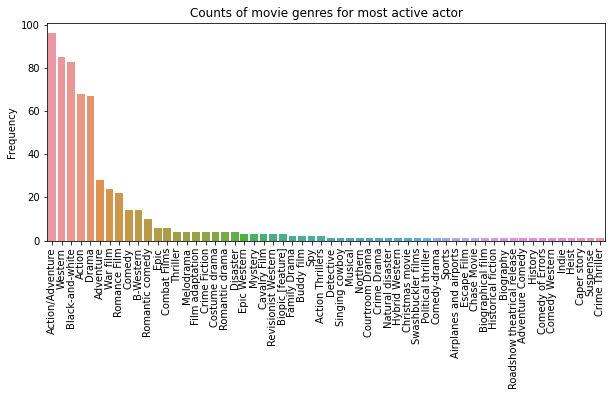

In [69]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()
actor_1 = top_actors["genres_freq"].iloc[0]

plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [70]:
actor_2 = top_actors["genres_freq"].iloc[1]

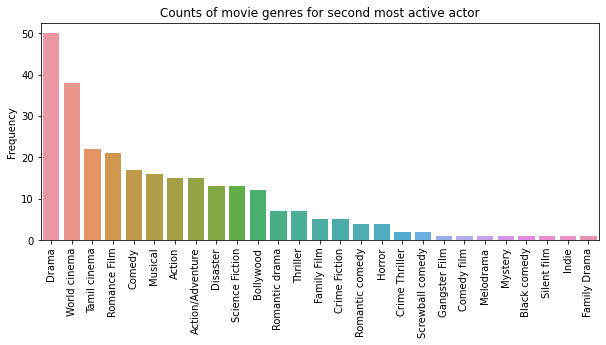

In [71]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [72]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [73]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [74]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [75]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [76]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

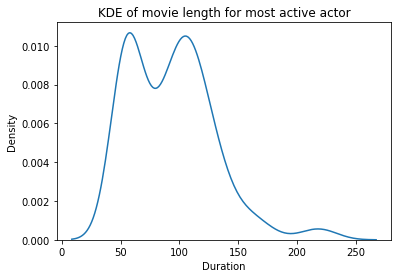

In [77]:
plt.title('KDE of movie length for most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

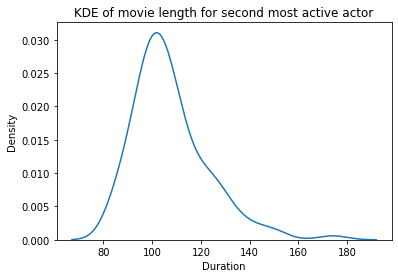

In [78]:
plt.title('KDE of movie length for second most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()